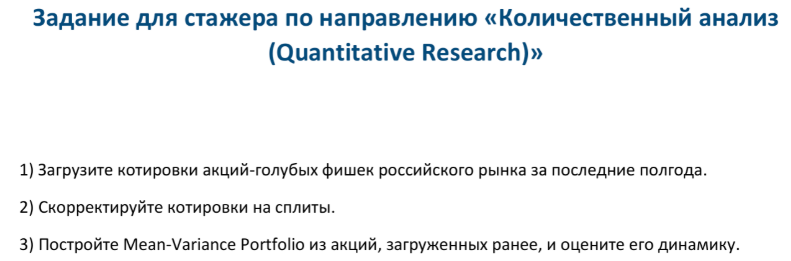

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import pandas as pd

from tqdm import tqdm
from dataclasses import dataclass
import warnings
import os

import jax
import jax.numpy as jnp
from jax import jit, vmap

from moexalgo import Market, Ticker
import cvxpy as cp

In [2]:
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

### Data mining

The stocks under consideration are from Moscow Exchange Blue Chip Index(MOEXBC): 15 most liquid stocks of Russian equity market.

Period of analysis: 6.12.2024 - 6.05.2025

List of MOEXBC index constituents as of 6.05.2025:

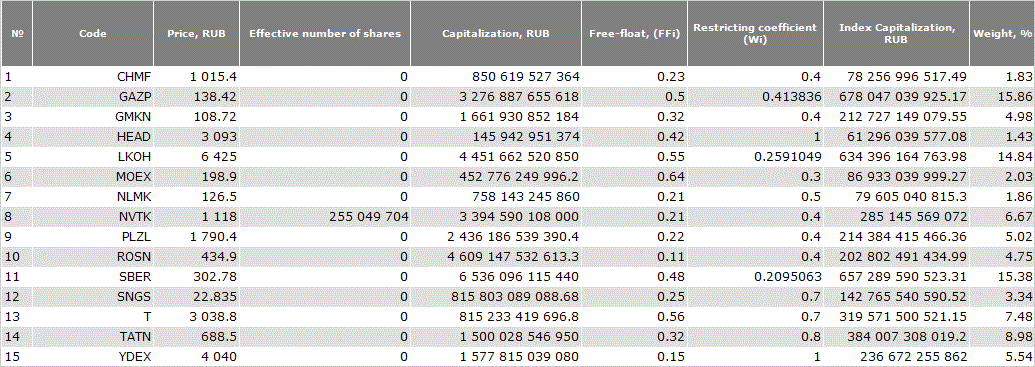 (_source: moex.com_)

In [3]:
#List of MOEXBC constituents

assets = [
    'CHMF', 'GAZP', 'GMKN', 'HEAD', 'LKOH',
    'MOEX', 'NLMK', 'NVTK', 'PLZL', 'ROSN',
    'SBER', 'SNGS', 'T', 'TATN', 'YDEX'
]

start = '2024-12-06'
end = '2025-05-06'
period = '1d' #data frequency

In [4]:
#data downloading
prices = pd.DataFrame()
for asset in assets:
    prices[asset] = Ticker(asset).candles(start=start, end=end, period=period)[['close']]
prices['timestamp'] = Ticker(assets[0]).candles(start=start, end=end, period=period)[['begin']]


prices.head(9)

CHMF    GAZP    GMKN    HEAD    LKOH    MOEX    NLMK   NVTK     PLZL  \
0  1097.4  114.99  107.80  4290.0  6860.0  178.20  120.80  833.2  1432.30   
1  1125.8  117.06  106.86  4313.0  6973.0  183.89  123.40  829.2  1479.90   
2  1098.8  114.70  103.60  4297.0  6894.0  179.08  119.38  811.6  1477.70   
3  1103.2  115.16  104.10  4231.0  6895.5  180.30  120.00  810.0  1504.40   
4  1083.0  113.10  100.30  4141.0  6862.5  175.71  116.04  791.2  1477.00   
5  1091.2  112.86   99.90  4010.0  6800.0  176.01  117.02  790.2  1369.25   
6  1054.4  108.71   95.90  3982.0  6779.5  171.64  115.04  767.2  1307.40   
7  1016.4  107.26   94.98  3060.0  6290.5  172.00  114.90  771.6  1362.00   
8  1033.8  108.05   95.66  3128.0  6375.0  175.47  116.94  784.8  1382.00   

     ROSN    SBER    SNGS       T   TATN    YDEX  timestamp  
0  485.30  237.84  23.270  2350.0  558.9  3376.0 2024-12-06  
1  491.05  237.29  23.740  2395.0  566.2  3466.0 2024-12-09  
2  484.60  230.82  23.040  2345.2  564.9  3379.5 2024-12-10  
3  488.75  234.19  23.085  2346.4  574.1  3397.0 2024-12-11  
4  485.45  229.02  22.665  2305.4  557.8  3284.0 2024-12-12  
5  483.65  228.70  22.665  2289.0  571.6  3321.0 2024-12-13  
6  477.40  225.53  22.185  2182.0  550.0  3232.5 2024-12-16  
7  480.65  226.50  21.950  2221.4  556.2  3248.5 2024-12-17  
8  487.70  230.15  22.400  2260.2  569.3  3255.0 2024-12-18

When working with stock price data, we have to account for corporate actions such as stock splits and dividend payments, as they impact return calculations.

1. **Stock Splits**
Stock splits are automatically reflected in the historical price series provided by the `moexalgo` package. Therefore, no additional adjustments are required to handle splits in the price data. The only impact splits have in our case is the divided value adjustment. During the observed period, the only known stock split is for **PLZL** on **27.03.2025**, executed with a **10:1** split ratio. This means that when we use dividends to compute adjusted returns we should devide the dividends by split ratio.

* **Dividends**
Unlike splits, dividend payments must be explicitly accounted for. To correctly compute total returns over ex-dividend dates, the absolute dividend amount (adjusted for any applicable splits) should be added to the closing price on the ex-dividend date.

#### Adjusted Dividend Gap Table

| Ticker | Ex-Dividend Date | Dividend (RUB)   | Adjustment Note         |
| ------ | ---------------- | ---------------- | ----------------------- |
| NVTK   | 28.04.2025       | 46.65            | —                       |
| PLZL   | 25.04.2025       | 73.00            | Post-split dividend     |
| ROSN   | 10.01.2025       | 36.47            | —                       |
| YDEX   | 28.04.2025       | 80.00            | —                       |
| TATN   | 08.01.2025       | 17.39            | —                       |
| PLZL   | 13.12.2024       | 1301.75 → 130.175 | Adjusted for 10:1 split |
| LKOH   | 17.12.2024       | 514.00           | —                       |
| CHMF   | 17.12.2024       | 49.06            | —                       |
| HEAD   | 17.12.2024       | 907.00           | —                       |

Closing prices:

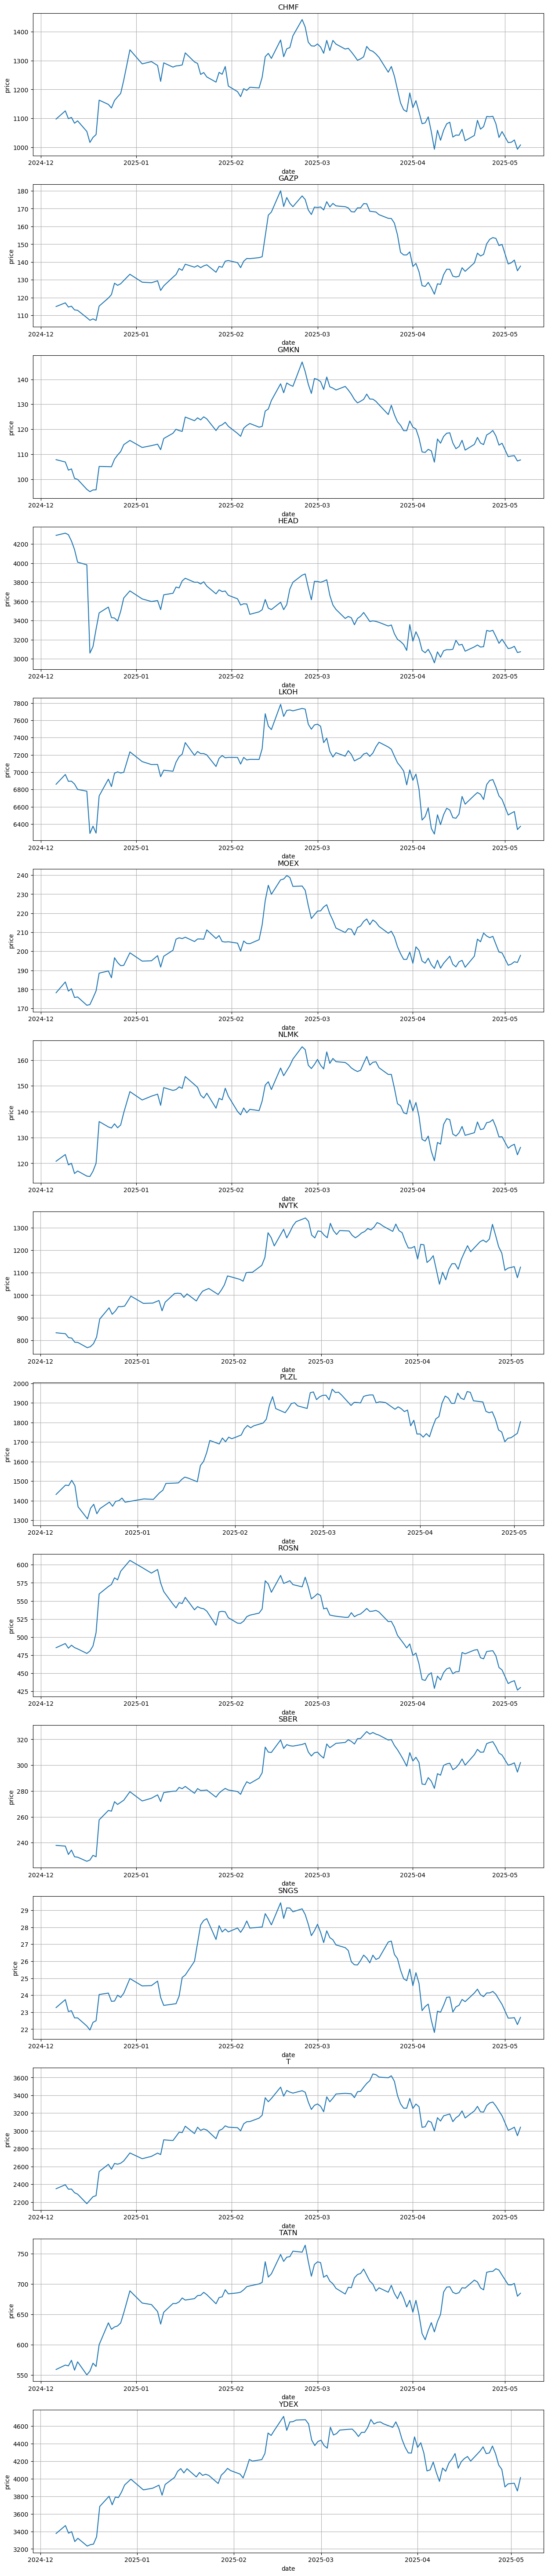

In [5]:
#prices plots
fig, axes = plt.subplots(nrows = len(assets), ncols = 1, figsize = (15, 5*len(assets)))

for i, asset in enumerate(assets):
    axes[i].plot(prices['timestamp'], prices[asset])
    axes[i].set_xlabel('date')
    axes[i].set_ylabel('price')
    axes[i].set_title(asset)
    axes[i].grid()

In [8]:
#dividend dict
dividends = {
    'PLZL': [(pd.to_datetime('2024-12-13'), 130.175), (pd.to_datetime('2025-04-25'), 73)],
    'LKOH': [(pd.to_datetime('2024-12-17'), 514)],
    'CHMF': [(pd.to_datetime('2024-12-17'), 49.06)],
    'HEAD': [(pd.to_datetime('2024-12-17'), 907)],
    'TATN': [(pd.to_datetime('2025-01-08'), 17.39)],
    'ROSN': [(pd.to_datetime('2025-01-10'), 36.47)],
    'NVTK': [(pd.to_datetime('2025-04-28'), 46.65)],
    'YDEX': [(pd.to_datetime('2025-04-28'), 80)]
}

returns = pd.DataFrame()
returns[assets] = prices[assets].pct_change()
returns['timestamp'] = prices['timestamp']

#dividend adjustment
for key in dividends.keys():
    for item in dividends[key]:
        idx = returns.index[returns['timestamp'] == item[0]]
        returns.loc[idx, key] += float(item[1]/prices.loc[idx-1, key])
        
returns.drop(labels = 0, axis = 0, inplace=True)
print('Dividend adjusted daily returns')
returns.head(8)

Dividend adjusted daily returns


CHMF      GAZP      GMKN      HEAD      LKOH      MOEX      NLMK  \
1  0.025879  0.018002 -0.008720  0.005361  0.016472  0.031930  0.021523   
2 -0.023983 -0.020161 -0.030507 -0.003710 -0.011329 -0.026157 -0.032577   
3  0.004004  0.004010  0.004826 -0.015360  0.000218  0.006813  0.005193   
4 -0.018310 -0.017888 -0.036503 -0.021272 -0.004786 -0.025458 -0.033000   
5  0.007572 -0.002122 -0.003988 -0.031635 -0.009107  0.001707  0.008445   
6 -0.033724 -0.036771 -0.040040 -0.006983 -0.003015 -0.024828 -0.016920   
7  0.010489 -0.013338 -0.009593 -0.003767  0.003688  0.002097 -0.001217   
8  0.017119  0.007365  0.007159  0.022222  0.013433  0.020174  0.017755   

       NVTK      PLZL      ROSN      SBER      SNGS         T      TATN  \
1 -0.004801  0.033233  0.011848 -0.002312  0.020198  0.019149  0.013061   
2 -0.021225 -0.001487 -0.013135 -0.027266 -0.029486 -0.020793 -0.002296   
3 -0.001971  0.018069  0.008564  0.014600  0.001953  0.000512  0.016286   
4 -0.023210 -0.018213 -0.006752 -0.022076 -0.018194 -0.017474 -0.028392   
5 -0.001264  0.015183 -0.003708 -0.001397  0.000000 -0.007114  0.024740   
6 -0.029107 -0.045171 -0.012923 -0.013861 -0.021178 -0.046745 -0.037789   
7  0.005735  0.041762  0.006808  0.004301 -0.010593  0.018057  0.011273   
8  0.017107  0.014684  0.014668  0.016115  0.020501  0.017466  0.023553   

       YDEX  timestamp  
1  0.026659 2024-12-09  
2 -0.024957 2024-12-10  
3  0.005178 2024-12-11  
4 -0.033265 2024-12-12  
5  0.011267 2024-12-13  
6 -0.026649 2024-12-16  
7  0.004950 2024-12-17  
8  0.002001 2024-12-18

Daily returns(close-close) time-series and distribution with statistics:

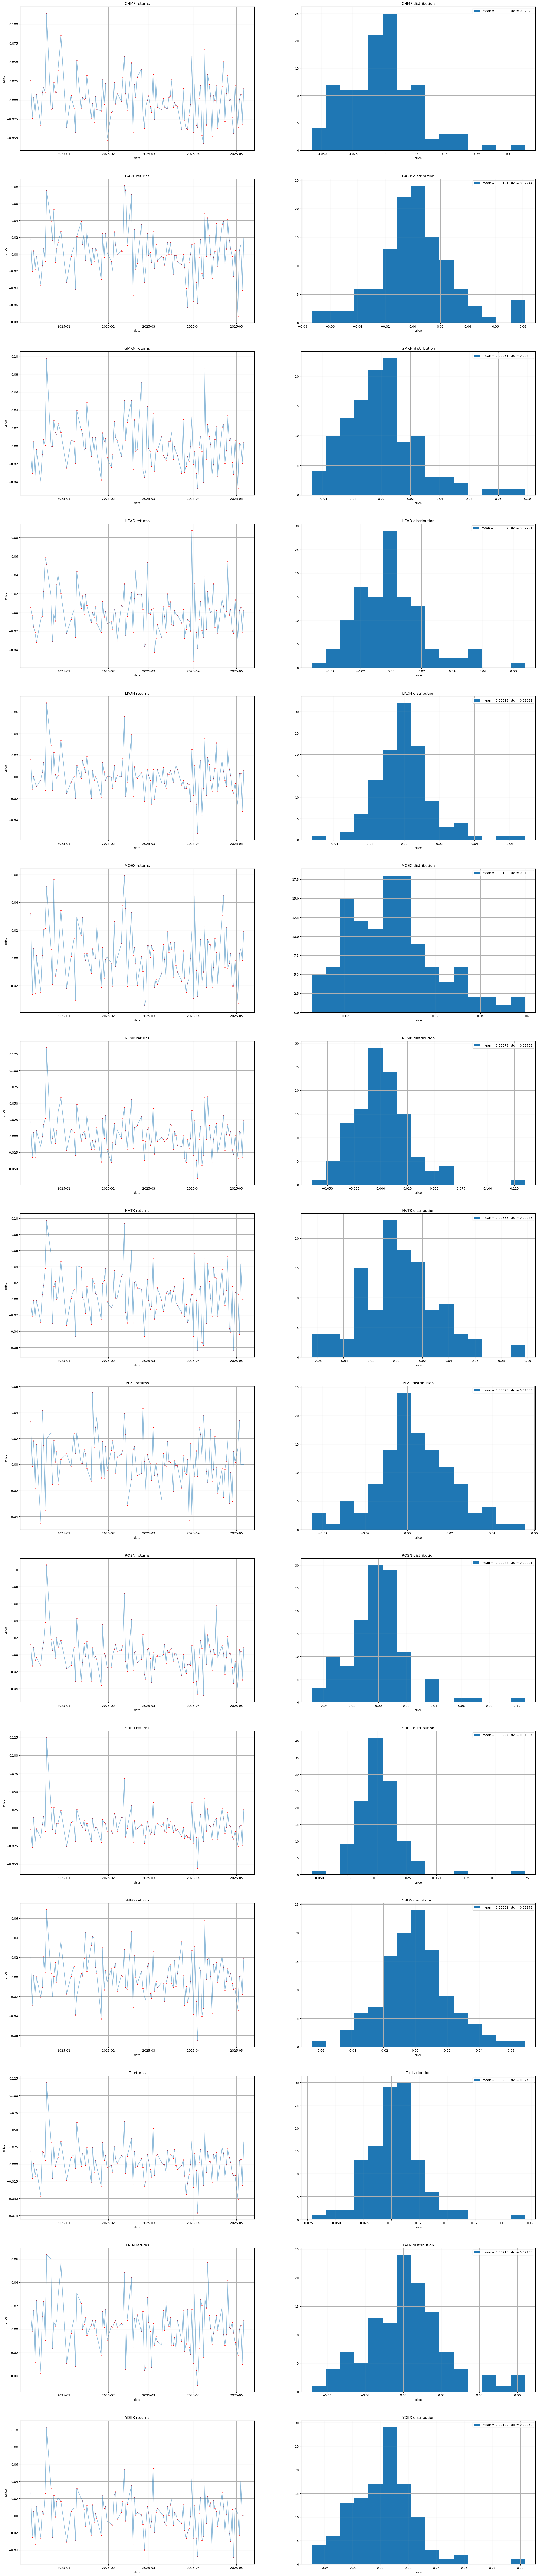

In [9]:
fig, axes = plt.subplots(nrows = len(assets), ncols = 2, figsize = (15*2, 10*len(assets)))

for i, asset in enumerate(assets):
    axes[i, 0].plot(returns['timestamp'], returns[asset], alpha = 0.5)
    axes[i, 0].scatter(returns['timestamp'], returns[asset], s = 5, c = 'red')
    axes[i, 0].set_xlabel('date')
    axes[i, 0].set_ylabel('price')
    axes[i, 0].set_title(asset + ' returns')
    axes[i, 0].grid()

    axes[i, 1].hist(returns[asset], bins = 15, label = f'mean = {returns[asset].mean():.5f}; std = {returns[asset].std():.5f}')
    axes[i, 1].set_xlabel('price')
    axes[i, 1].set_title(asset + ' distribution')
    axes[i, 1].grid()
    axes[i, 1].legend()

Computation of returns expectations and covariance:

In [10]:
#To annualize covariance and mean we multiply daily
#values by a typical number of trading days in a year

returns_cov = np.cov(np.array(returns[assets]).T)*252
returns_mean = np.mean(np.array(returns[assets]).T, axis = 1)*252

returns_mean = np.expand_dims(returns_mean, axis = 1)

Vizualization of covariance matrix:

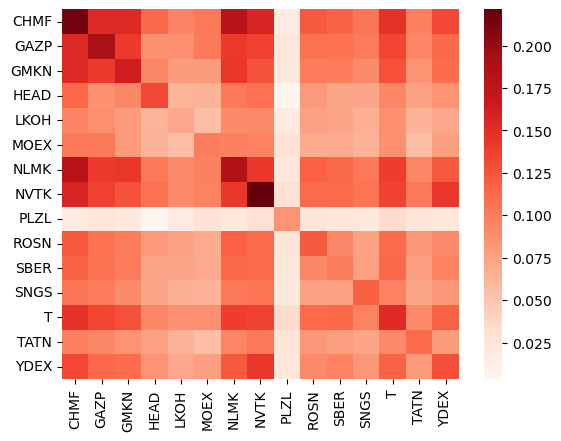

In [11]:
sns.heatmap(data = returns_cov, xticklabels = assets, yticklabels = assets, cmap = 'Reds')
plt.show()

One reason for the relatively low correlation between PLZL and other stocks in the portfolio is its strong relationship with gold prices. Further analysis indicates that the performance of PLZL closely tracks the dynamics of the gold market.

### Optimization

We aim to construct a portfolio that maximizes expected return, subject to a fixed level of portfolio risk (volatility). The problem is formulated as:

Let:  
- $\mu \in \mathbb{R}^n$ be the vector of expected annualized returns for $n$ assets.  
- $\Sigma \in \mathbb{R}^{n \times n}$ be the covariance matrix of asset returns.  
- $w \in \mathbb{R}^n$ be the vector of portfolio weights.  

The optimization problem is:

$$
\begin{aligned}
\max_{w \in \mathbb{R}^n} \quad & \mu^\top w \\\\
\text{subject to} \quad 
& w^\top \Sigma w \leq \sigma_{\text{target}}^2 \\\\
& \mathbf{1}^\top w = 1 \\\\
& w_i \geq 0 \quad \text{for } i = 1, \dots, n
\end{aligned}
$$

Where:
- $\sigma_{\text{target}}$ is the target portfolio volatility.  
- The constraint $\mathbf{1}^\top w = 1$ ensures the portfolio is fully invested.  
- The non-negativity constraint $w_i \geq 0$ ensures long-only allocations.

This convex optimization problem is solved via `cvxpy` package.

In [12]:
class Portfolio:

    def get_statistics(self, w:np.array):
        """
        returns expected value and volatility of a portfolio
        given the weights
        """
        w = np.expand_dims(w, axis = 1)
        EV = float(np.matmul(w.T, returns_mean))
        Var = float(np.matmul(np.matmul(w.T, returns_cov), w))
        return EV, np.sqrt(Var)
        
    def efficient_frontier_w(self, target_vol):
        """
        returns weights that are maximizing and minimizing expected
        returns given target volatility
        """
        w = cp.Variable(len(assets))
        constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, returns_cov) <= target_vol**2]
        
        objective_max = cp.Maximize(w.T@returns_mean)
        problem = cp.Problem(objective_max, constraints)
        problem.solve()
        w_max = w.value

        objective_min = cp.Minimize(w.T@returns_mean)
        problem = cp.Problem(objective_min, constraints)
        problem.solve()
        w_min = w.value

        return w_max, w_min     

Another metric used in our analysis is Sharpe ratio:

$$
\text{Sharpe}(w) = \frac{\mu^\top w - R_f}{\sqrt{w^\top \Sigma w}}
$$

Where:
- $w \in \mathbb{R}^n$ is the portfolio weight vector.
- $\mu \in \mathbb{R}^n$ is the vector of expected returns.
- $R_f$ is the risk-free rate (annualized).
- $\Sigma \in \mathbb{R}^{n \times n}$ is the covariance matrix of asset returns.

The optimization problem is:

$$
\max_{w \in \mathbb{R}^n} \ \frac{\mu^\top w - R_f}{\sqrt{w^\top \Sigma w}}
$$

Subject to:
- $\sum_{i=1}^n w_i = 1$ (fully invested portfolio),
- $w_i \geq 0$ for all $i$ (long-only constraint, optional).

To solve this problem we use a custom projected gradient descend optimizer.

The resulting portfolio maximizes excess return per unit of risk and lies on the efficient frontier.


To calculate Sharpe ratio and for the purposes of a next section we need a notion of a risk free rate. We use the daily risk-free rate implied by the one-year zero-coupon yield curve (ZCYC) over the past six months(from moex).

In [13]:
zcyc = pd.read_csv('./zcyc.csv')
zcyc['date'] = zcyc['date'].apply(lambda s: pd.to_datetime(str(s), dayfirst=True))

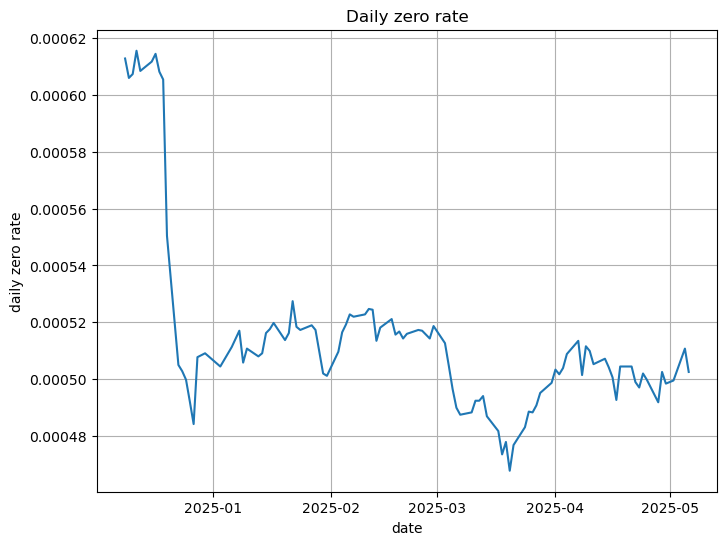

In [14]:
zcyc['rate'] = zcyc['rate']/100/365
plt.figure(figsize = (8, 6))
plt.plot(zcyc['date'], zcyc['rate'])
plt.xlabel('date')
plt.ylabel('daily zero rate')
plt.title('Daily zero rate')
plt.grid()

Because ZCYC quotes are only published on trading days, we interpolate or forward-fill missing dates to create a continuous daily rate series.

In [15]:
def fill_zcyc_calendar(df: pd.DataFrame):
    df_indexed = df.sort_values('date').set_index('date')
    full_idx = pd.date_range(start=df_indexed.index.min(), end=df_indexed.index.max(), freq='D')
    df_filled = df_indexed.reindex(full_idx).ffill()
    df_filled = df_filled.reset_index()
    df_filled.columns = ['date', 'rate']

    return df_filled

zcyc = fill_zcyc_calendar(zcyc)

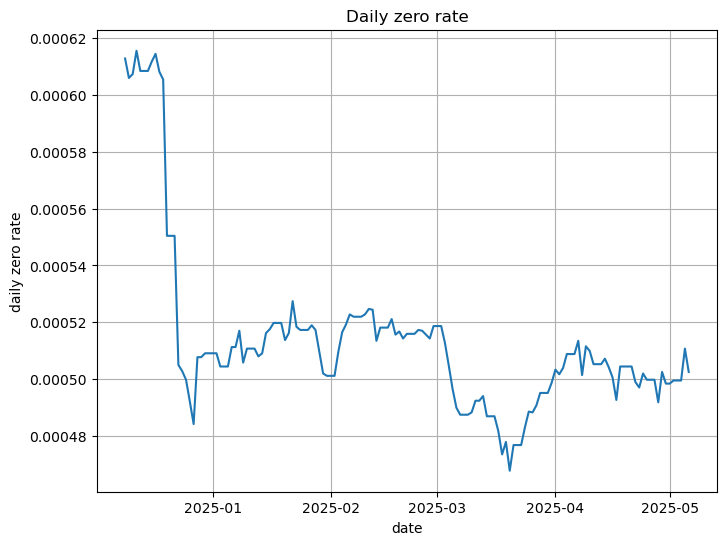

In [16]:
plt.figure(figsize = (8, 6))
plt.plot(zcyc['date'], zcyc['rate'])
plt.xlabel('date')
plt.ylabel('daily zero rate')
plt.title('Daily zero rate')
plt.grid()

As a risk free rate for the Sharpe ratio computation we take average annualized rate:

In [17]:
rf = np.mean(zcyc['rate'])*365
print(f'risk-free rate = {rf:.5}')

risk-free rate = 0.18751


Back to Sharpe ratio optimization:

In [20]:
def sharpe_ratio(w, mu, cov, rf):
    ret = jnp.dot(mu, w)
    vol = jnp.sqrt(w @ cov @ w)
    return (ret - rf) / vol

def project_to_simplex(w):
    w_sorted = jnp.sort(w)[::-1]
    cssv = jnp.cumsum(w_sorted) - 1
    ind = jnp.arange(1, w.shape[0] + 1)
    cond = w_sorted - cssv / ind > 0
    rho = jnp.sum(cond)
    theta = cssv[rho - 1] / rho
    return jnp.maximum(w - theta, 0.0)

@jax.jit
def gradient_step(w, mu, cov, rf, lr):
    grad_fn = jax.grad(sharpe_ratio)
    grad = grad_fn(w, mu, cov, rf)
    w_new = w + lr * grad
    return project_to_simplex(w_new)

def optimize_sharpe(mu, cov, rf, lr=0.01, steps=500):
    n = len(mu)
    w = jnp.ones(n) / n

    for _ in range(steps):
        w = gradient_step(w, mu, cov, rf, lr)

    max_sharpe = sharpe_ratio(w, mu, cov, rf)
    return w, max_sharpe


In [22]:
weights, sharpe = optimize_sharpe(returns_mean.squeeze(), returns_cov, rf)
print("Optimal weights:", weights)
print("Max Sharpe ratio:", sharpe)

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.2326567  0.76734334 0.         0.         0.
 0.         0.         0.        ]
Max Sharpe ratio: 2.3668344


Simulating random portfolios:

In [23]:
portfolio = Portfolio()

N = 10_000
EV = np.zeros(N)
Vol = np.zeros(N)
alpha = np.full(shape=len(assets), fill_value=0.1)

for i in range(N):
    w = sp.stats.dirichlet.rvs(alpha = alpha)
    w = w.squeeze()
    EV[i], Vol[i] = portfolio.get_statistics(w)

Find minimal volatility portfolio:

In [24]:
w = cp.Variable(len(assets))
objective = cp.Minimize(cp.quad_form(w, returns_cov))
constraints = [cp.sum(w) == 1, w >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()
min_vol_w = w.value
min_vol = np.sqrt(min_vol_w.T@returns_cov@min_vol_w)
print(f'minimal portfolio volatility = {min_vol:.5}')

minimal portfolio volatility = 0.21409


Computation&Vizualization of efficient frontier:

In [25]:
n = 100
EV_opt_max = np.zeros(n)
EV_opt_min = np.zeros(n)
Vol_opt = np.linspace(min_vol+1e-6, np.max(Vol), n)
for i in range(n):
    w_max, w_min = portfolio.efficient_frontier_w(Vol_opt[i])
    EV_opt_max[i] = w_max.T@returns_mean
    EV_opt_min[i] = w_min.T@returns_mean

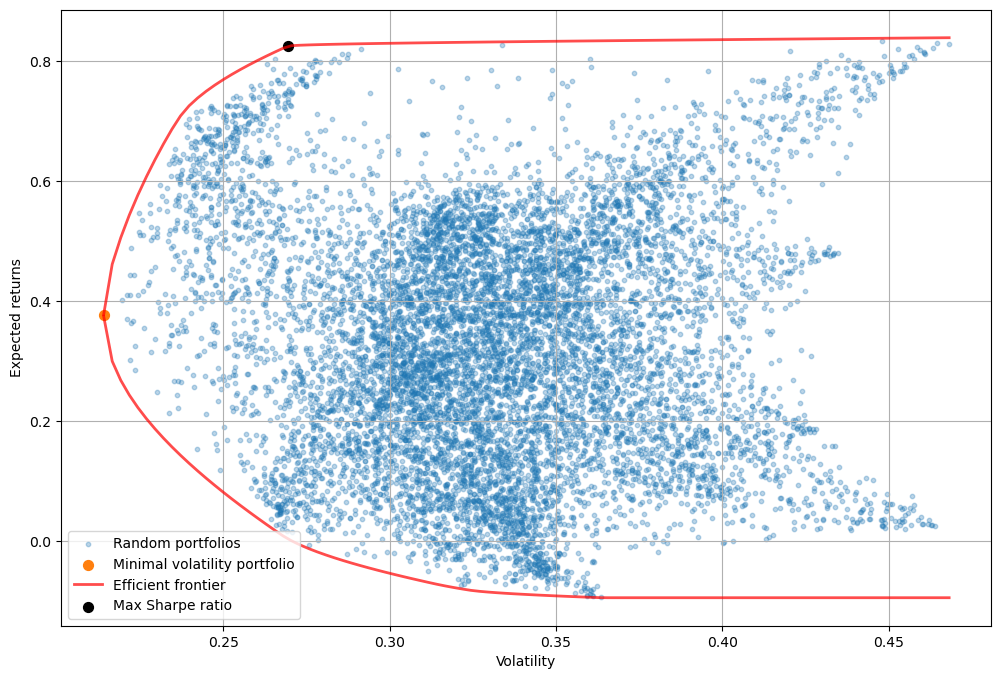

In [26]:
plt.figure(figsize = (12, 8))
plt.scatter(Vol, EV, s = 10, alpha = 0.3, label = 'Random portfolios')
plt.scatter(min_vol, min_vol_w.T@returns_mean, label = 'Minimal volatility portfolio', s = 50)
plt.plot(Vol_opt, EV_opt_max, c = 'red', lw = 2, alpha = 0.7, label = 'Efficient frontier')
plt.plot(Vol_opt, EV_opt_min, c = 'red', lw = 2, alpha = 0.7)
plt.scatter(np.sqrt(weights.T@returns_cov@weights), weights.T@returns_mean, label = 'Max Sharpe ratio', c = 'black', s = 50)
plt.xlabel('Volatility')
plt.ylabel('Expected returns')
plt.legend()
plt.grid()

### Dynamics

To assess the  dynamics of a mean-variance portfolio we should set some target volatility.
As our target benchmark volatility we can take volatility of MOEXBC itself.

In [27]:
moexbc = pd.read_csv('./moexbc.csv')

In [28]:
moexbc['date'] = moexbc['date'].apply(lambda s: pd.to_datetime(str(s), dayfirst=True))
moexbc.head(5)

date     close
0 2024-12-06  16347.28
1 2024-12-09  16575.95
2 2024-12-10  16279.42
3 2024-12-11  16213.55
4 2024-12-12  16098.81

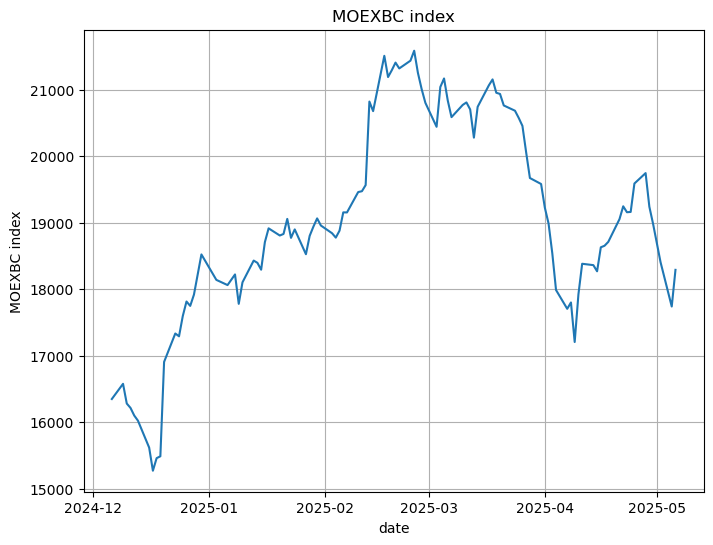

In [29]:
plt.figure(figsize = (8, 6))
plt.plot(moexbc['date'], moexbc['close'])
plt.xlabel('date')
plt.ylabel('MOEXBC index')
plt.title('MOEXBC index')
plt.grid()

In [30]:
returns_moexbc = pd.DataFrame()
returns_moexbc['returns'] = moexbc['close'].pct_change()
returns_moexbc['date'] = moexbc['date']

returns_moexbc.drop(labels = 0, axis = 0, inplace=True)

returns_moexbc.head(5)

returns       date
1  0.013988 2024-12-09
2 -0.017889 2024-12-10
3 -0.004046 2024-12-11
4 -0.007077 2024-12-12
5 -0.004835 2024-12-13

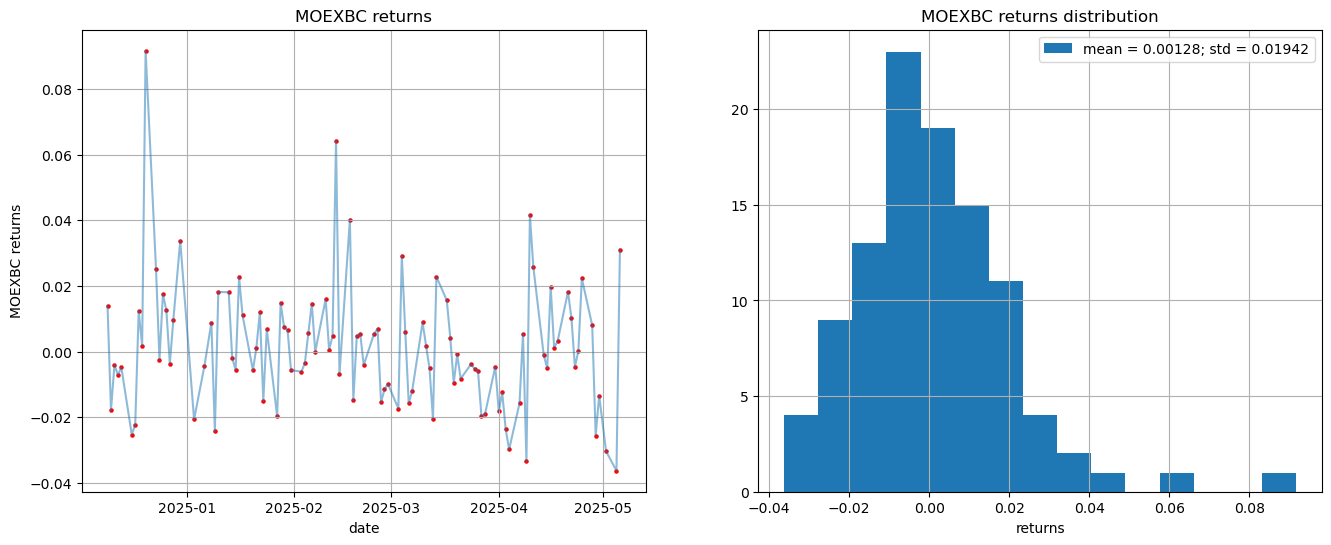

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

axes[0].plot(returns_moexbc['date'], returns_moexbc['returns'], alpha = 0.5)
axes[0].scatter(returns_moexbc['date'], returns_moexbc['returns'], s = 5, c = 'red')
axes[0].set_xlabel('date')
axes[0].set_ylabel('MOEXBC returns')
axes[0].set_title('MOEXBC returns')
axes[0].grid()

axes[1].hist(returns_moexbc['returns'], bins = 15, label = f'mean = {returns_moexbc['returns'].mean():.5f}; std = {returns_moexbc['returns'].std():.5f}')
axes[1].set_xlabel('returns')
axes[1].set_title('MOEXBC returns distribution')
axes[1].grid()
axes[1].legend()

In [32]:
#computing moexbc returns volatility
moexbc_vol = np.sqrt(np.var(returns_moexbc['returns'])*252)
print(f'MOEXBC volatility = {moexbc_vol:.5}')

MOEXBC volatility = 0.30672


Given MOEXBC volatility we can compute mean-variance portfolio weights and then compute compounded returns:

In [33]:
#compute the mean-variance portfolio corresponding to the 
#volatility of the MOEXBC
w_max, _ = portfolio.efficient_frontier_w(moexbc_vol)
portfolio_returns = np.array(returns.drop(columns = ['timestamp']))@w_max
total_returns = np.cumprod(1 + portfolio_returns) - 1

#Compute total returns of MOEXBC and risk-free:

total_moexbc_returns = np.cumprod(1 + returns_moexbc['returns']) - 1
zcyc_total_returns = np.cumprod(1 + zcyc['rate']) - 1

Total returns vizualization:

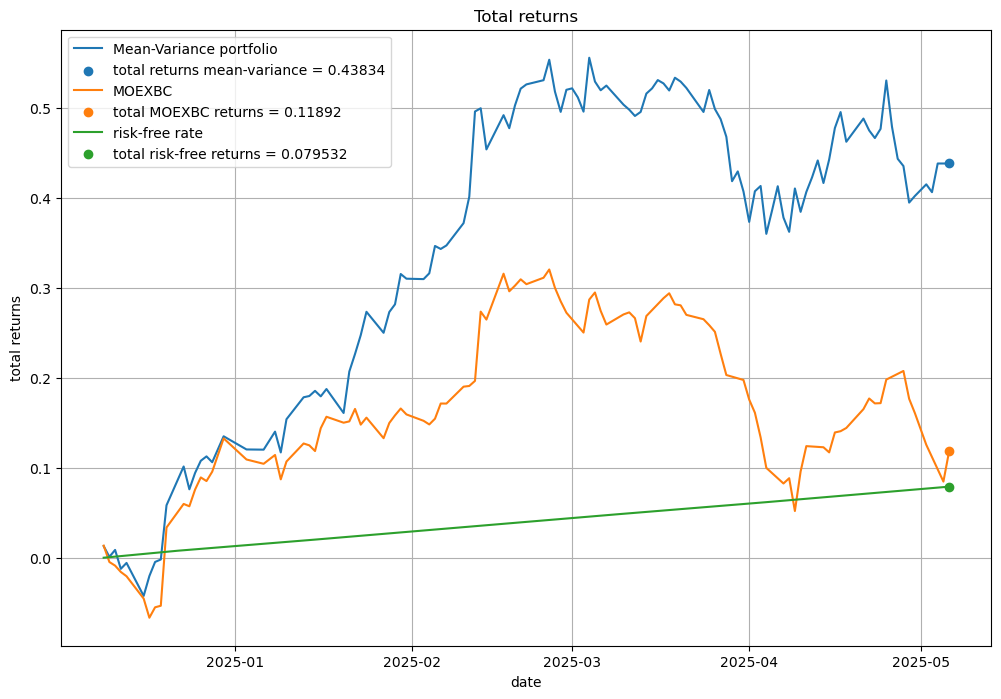

In [34]:
plt.figure(figsize = (12, 8))
plt.plot(returns['timestamp'], total_returns , label = 'Mean-Variance portfolio')
plt.scatter(returns['timestamp'].iloc[-1], total_returns[-1] , label = f'total returns mean-variance = {total_returns[-1]:.5}')
plt.plot(returns_moexbc['date'], total_moexbc_returns, label = 'MOEXBC')
plt.scatter(returns_moexbc['date'].iloc[-1], total_moexbc_returns.iloc[-1], label = f'total MOEXBC returns = {total_moexbc_returns.iloc[-1]:.5}')
plt.plot(zcyc['date'], zcyc_total_returns, label = 'risk-free rate')
plt.scatter(zcyc['date'].iloc[-1], zcyc_total_returns.iloc[-1], label = f'total risk-free returns = {zcyc_total_returns.iloc[-1]:.5}')
plt.xlabel('date')
plt.ylabel('total returns')
plt.title('Total returns')
plt.grid()
plt.legend()


Portfolio weights:

In [35]:
final_portfolio = pd.DataFrame()
final_portfolio['Ticker'] = assets
final_portfolio['weights'] = w_max
final_portfolio['weights'] = final_portfolio['weights'].apply(lambda x: x*(x>1e-6))

final_portfolio = final_portfolio.T
print(f'portfolio Sharpe ratio = {sharpe_ratio(w_max, returns_mean.squeeze(), returns_cov, rf):.5}')
final_portfolio

portfolio Sharpe ratio = 2.0961


0     1     2     3     4     5     6         7         8     9   \
Ticker   CHMF  GAZP  GMKN  HEAD  LKOH  MOEX  NLMK      NVTK      PLZL  ROSN   
weights   0.0   0.0   0.0  -0.0   0.0   0.0   0.0  0.519276  0.480724  -0.0   

           10    11   12    13    14  
Ticker   SBER  SNGS    T  TATN  YDEX  
weights   0.0   0.0  0.0   0.0   0.0

Over December 2024–May 2025, our mean–variance portfolio delivered a total return of about 43.8%(semi-annually) versus 11.9%(semi-annually) for the MOEXBC index and 7.9%(semi-anually) for cash, achieving an annualized Sharpe ratio of 2.096.

Repo with my other financial projects/excercises:

https://github.com/Kirill-Prokopov/Portfolio